In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# making train data
path = "/Users/sabosan/data/UCI_HAR_Dataset/train/Inertial_Signals/"
ax = np.loadtxt(path+"body_acc_x_train.txt")
ay = np.loadtxt(path+"body_acc_y_train.txt")
az = np.loadtxt(path+"body_acc_z_train.txt")
path_label = "/Users/sabosan/data/UCI_HAR_Dataset/train/y_train.txt"
y_train = np.loadtxt(path_label); y_train = np.array(y_train,int)
# 1-6 -> 0-5
y_train[:] = y_train[:]-1
# one-hot
y_train =  np.eye(6)[y_train]

ax = np.reshape(ax,(7352,128,1))
ay = np.reshape(ay,(7352,128,1))
az = np.reshape(az,(7352,128,1))

# 3ch data
acc = ax.copy()
acc = np.append(acc,ay,axis=2)
acc = np.append(acc,az,axis=2)
acc = np.transpose(acc,(1,0,2))
X_train = acc
print("(seq_len, bt_size, vec_size)")
print(X_train.shape)

(seq_len, bt_size, vec_size)
(128, 7352, 3)


In [3]:
# making test data
path = "/Users/sabosan/data/UCI_HAR_Dataset/test/Inertial_Signals/"
ax = np.loadtxt(path+"body_acc_x_test.txt")
ay = np.loadtxt(path+"body_acc_y_test.txt")
az = np.loadtxt(path+"body_acc_z_test.txt")
path_label = "/Users/sabosan/data/UCI_HAR_Dataset/test/y_test.txt"
y_test = np.loadtxt(path_label); y_test = np.array(y_test,int)
# 1-6 -> 0-5
y_test[:] = y_test[:]-1
# one-hot
y_test =  np.eye(6)[y_test]

# 3ch data
ax = np.reshape(ax,(2947,128,1))
ay = np.reshape(ay,(2947,128,1))
az = np.reshape(az,(2947,128,1))
acc = ax.copy()
acc = np.append(acc,ay,axis=2)
acc = np.append(acc,az,axis=2)
acc = np.transpose(acc,(1,0,2))
X_test = acc
print("(seq_len, bt_size, vec_size)")
print(X_test.shape)
print(y_test.shape)

(seq_len, bt_size, vec_size)
(128, 2947, 3)
(2947, 6)


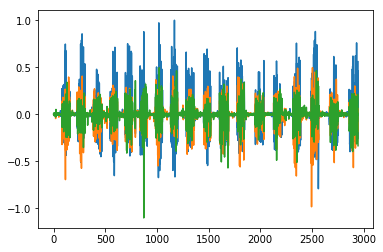

In [4]:
num_samp = np.arange(0,X_test.shape[1]) 

i = 100
plt.plot(num_samp,ax[:,i])
plt.plot(num_samp,ay[:,i])
plt.plot(num_samp,az[:,i])
plt.show()

In [5]:
import torch
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(MyLSTM, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層
        
        return output

In [6]:
# making batch randomly
def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [8]:
import torch.optim as optim #

vec_size = 3
hidden_size = 5 
out_dim = 6

epochs_num = 1000
training_size = 7352 
test_size = 2947
batch_size = 100

model = MyLSTM(vec_size, hidden_size, out_dim) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # decay入れる